{'odor--6093': {'f--1615': 'p', 'c--145': 'p', 'a--277': 'e', 'l--301': 'e', 'p--203': 'p', 's--426': 'p', 'm--28': 'p', 'n--2662': {'stalk-color-below-ring--2662': {'w--1511': {'odor--1511': {'y--339': {'veil-type--339': {'p--339': {'veil-type--339': {'f--339': 'e'}}}}, 'f--684': 'e', 'g--4': 'p', 's--484': {'veil-type--484': {'p--484': {'veil-type--484': {'f--484': 'e'}}}}}}, 'o--133': 'e', 'p--433': 'e', 'g--433': 'e', 'e--72': 'e', 'n--61': {'odor--61': {'s--4': 'e', 'f--25': {'veil-type--25': {'p--25': {'veil-type--25': {'f--25': 'e'}}}}, 'y--32': {'veil-type--32': {'p--32': {'veil-type--32': {'f--32': 'e'}}}}}}, 'y--19': 'p'}}, 'y--436': 'p'}}
Выбранные признаки:
['veil-type', 'stalk-color-below-ring', 'odor', 'gill-attachment', 'cap-surface']
Предсказанный:
['p', 'e', 'e', '-', '-', 'e', 'p', 'p', 'e', 'p', '-', '-', '-', 'e', 'e', 'p', 'e', 'p', '-', 'e', 'p', 'p', 'p', 'p', 'p', 'p', 'p', '-', 'e', 'p', 'p', 'p', 'p', 'p', 'p', '-', 'p', 'e', 'p', 'p', 'p', 'p', 'e', 'p', '-',

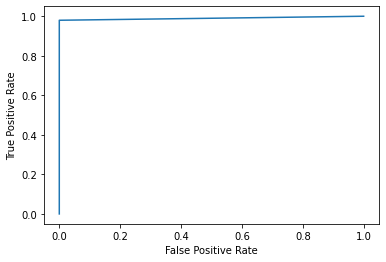

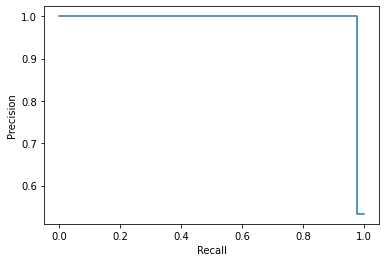

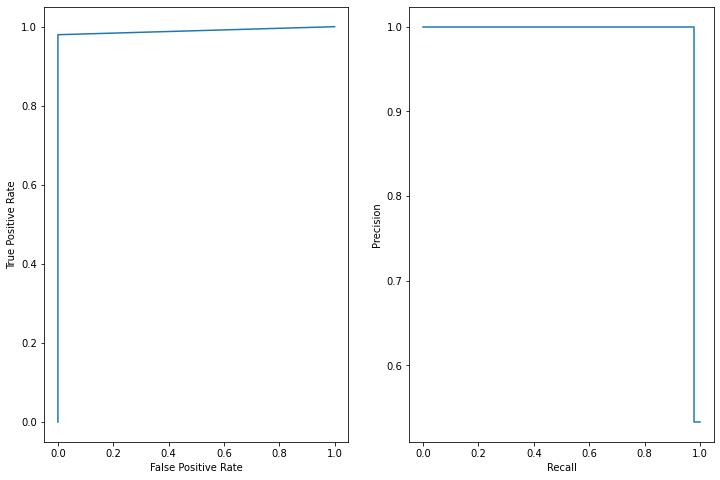

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, auc, average_precision_score, precision_score, recall_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

column_names = {
    '1': 'cap-shape',
    '2': 'cap-surface',
    '3': 'cap-color',
    '4': 'bruises?',
    '5': 'odor',
    '6': 'gill-attachment',
    '7': 'gill-spacing',
    '8': 'gill-size',
    '9': 'gill-color',
    '10': 'stalk-shape',
    '11': 'stalk-root',
    '12': 'stalk-surface-above-ring',
    '13': 'stalk-surface-below-ring',
    '14': 'stalk-color-above-ring',
    '15': 'stalk-color-below-ring',
    '16': 'veil-type',
    '17': 'veil-color',
    '18': 'ring-number',
    '19': 'ring-type',
    '20': 'spore-print-color',
    '21': 'population',
    '22': 'habitat'
                 }


def draw_plt(predict_arr, expect_arr):
    y_true = np.array([0 if x == 'p' else 1 for x in predict_arr])
    y_score = np.array([0 if x == 'p' else 1 if x == 'e' else '-1' for x in expect_arr])

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    auc_roc = auc(fpr, tpr)
    auc_pr = average_precision_score(y_true, y_score)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    plt.show()

def analyze(predict_arr, expect_arr):
    print("Recall:", recall_score(expect_arr, predict_arr, average="micro"))
    print("Accuracy:", accuracy_score(expect_arr, predict_arr))
    print("Precision:", precision_score(expect_arr, predict_arr, average="micro"))


def get_entropy(names):
    entropy = 0
    for name in set(names):
        p = names[names == name].shape[0] / names.shape[0]
        entropy -= p * np.log2(p)
    return entropy

def get_condition_entropy(names, cl):
    entropy = 0
    for name in set(names):
        c = cl[names == name]
        tmp_ent = get_entropy(c)
        p = c.shape[0] / cl.shape[0]
        entropy += p * tmp_ent
    return entropy

def get_split_info(names, cl):
    info = 0
    for name in set(names):
        c = cl[names == name]
        p = c.shape[0] / cl.shape[0]
        info -= p * np.log2(p)
    return info

def gain_info(names, cl):
    return (get_entropy(names) - get_condition_entropy(names, cl)) / (get_split_info(names, cl)+0.0000001)

def built_tree(names, cl, depth=1):
    if len(set(cl)) == 1:
        return cl[0]

    class_1, class_2 = set(cl)
    max = class_1 if np.sum(cl == class_1) > np.sum(cl == class_2) else class_2

    if depth > 10:
        return max

    if len(cl) < 1:
        return max

    if len(names[0]) == 0:
        return max

    index_best = 0
    max_gain = 0

    for name_index in range(len(names[0])):
        gain = gain_info(names[:, name_index], cl)
        if max_gain < gain:
            max_gain = gain
            index_best = name_index

    T = {}
    sub_T = {}

    for best_name in set(names[:, index_best]):
        sub_y = cl[names[:, index_best] == best_name]
        sub_X = names[names[:, index_best] == best_name]
        sub_X = np.delete(sub_X, index_best, 1)

        sub_T[best_name + "--" + str(len(sub_X))] = built_tree(sub_X, sub_y, depth + 1)

    T[cols_name[index_best] + "--" + str(len(names))] = sub_T

    return T

def make_pred(x, tree=None):
    if x.ndim == 2:
        res = []
        for x_el in x:
            res.append(make_pred(x_el))
        return res

    global main_tree
    if not tree:
        tree = main_tree
    
    key = list(tree.keys())[0]
    
    name = key.split("--")[0]

    try:
        index = cols_name.index(name)
    except ValueError:
        return '-'

    curr_tree = tree[key]

    for k in curr_tree.keys():
        if k.split("--")[0] == x[index]:
            key = k
            curr_tree = curr_tree[key]

    if type(curr_tree) == dict:
        return make_pred(x, curr_tree)
    else:
        return curr_tree


data = pd.read_csv("agaricus-lepiota.data", header=None)

Class = data.iloc[:, 0]
Names = data.iloc[:, 1:]

Names = Names.sample(n=5, axis=1)

cols = Names.columns.tolist()
cols_new = [column_names.get(str(x)) for x in cols]

global cols_name
global main_tree

main_tree = dict()
cols_name = cols_new

Names = Names.values
Class = Class.values

Names_train, Names_test, Class_train, Class_test = train_test_split(Names, Class, random_state=0)

main_tree = built_tree(Names_train, Class_train)
predict = make_pred(Names_test)

print(main_tree)
print("Выбранные признаки:")
print(cols_new)
print("Предсказанный:")
print(predict)
print("Ожидаемый:")
print(Class_test.tolist())

analyze(predict, Class_test)
draw_plt(predict, Class_test)